## Imports de bibliotecas e Carregamento dos Dados

In [1]:
# Imports das bibliotecas

# Para instalar todas as dependências necessárias, remova o '#' da linha abaixo e execute o comando:
# !pip install -r requirements.txt

# Imports para manipulação de dados
import pandas as pd
import numpy as np

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para análise e modelagem de séries temporais
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox

# Imports para modelagem preditiva
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Filtrando warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Formatação para os gráficos e tabelas

plt.style.use('ggplot')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# Formatando os labels dos gráficos

m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [4]:
# Carregando e visualizando os dados
df = pd.read_csv(r'.\datasets\dataset.csv')

# Visualizando os dados
print("Visualizando a tabela crua:")
df.head()

Visualizando a tabela crua:


,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


In [5]:
# Coletando somente as colunas de "Car_id" e "Date" e adicionando em um novo DataFrame
df = df[['Car_id', 'Date']]

# Realizando a contagem de carros vendidos por dia
df = df.groupby('Date')['Car_id'].nunique().reset_index(name='values')

# Alterando o nome da coluna "Date"
df = df.rename(columns={'Date': 'date'})

# Visualizando os dados agrupados
print("Visualizando os dados agrupados:")
df.head()

Visualizando os dados agrupados:


,date,values
0,1/10/2022,5
1,1/10/2023,15
2,1/11/2023,20
3,1/12/2022,30
4,1/13/2022,20


## Pré Processamento e Visualização dos Dados

In [6]:
# Convertendo a coluna data de object para datetime
df['date'] = pd.to_datetime(df['date'])

# Realizando a ordenação dos dados por data
df = df.sort_values(by='date')

# Coletando o período completo da série temporal
print('Início do Período de Tempo: {}\nFinal do Período de Tempo: {}'.format(df.date.min(), df.date.max()))

# Transformando a coluna de data no índice do conjunto de dados
# Isso irá facilitar nosso trabalho mais a frente
df = df.set_index('date')

# Definindo a frequência da série temporal como diária
df = df.asfreq('D')

# Verificando se a série tem algum valor nulo
nan_values = df['values'].isnull().sum()
print(f"\nA nossa série temporal tem {nan_values} valores nulos")

Início do Período de Tempo: 2022-01-02 00:00:00
Final do Período de Tempo: 2023-12-31 00:00:00

A nossa série temporal tem 117 valores nulos


In [7]:
# Realizando o tratamento dos valores ausentes com média móvel
df['values'] = df['values'].fillna(round(df['values'].rolling(window=7, min_periods=1).mean()))

# Verificando se a série continua apresentando algum valor nulo
nan_after_clean = df['values'].isnull().sum()
print(f"\nApós a limpeza, nossa série temporal apresenta {nan_after_clean} valores nulos")


Após a limpeza, nossa série temporal apresenta 0 valores nulos


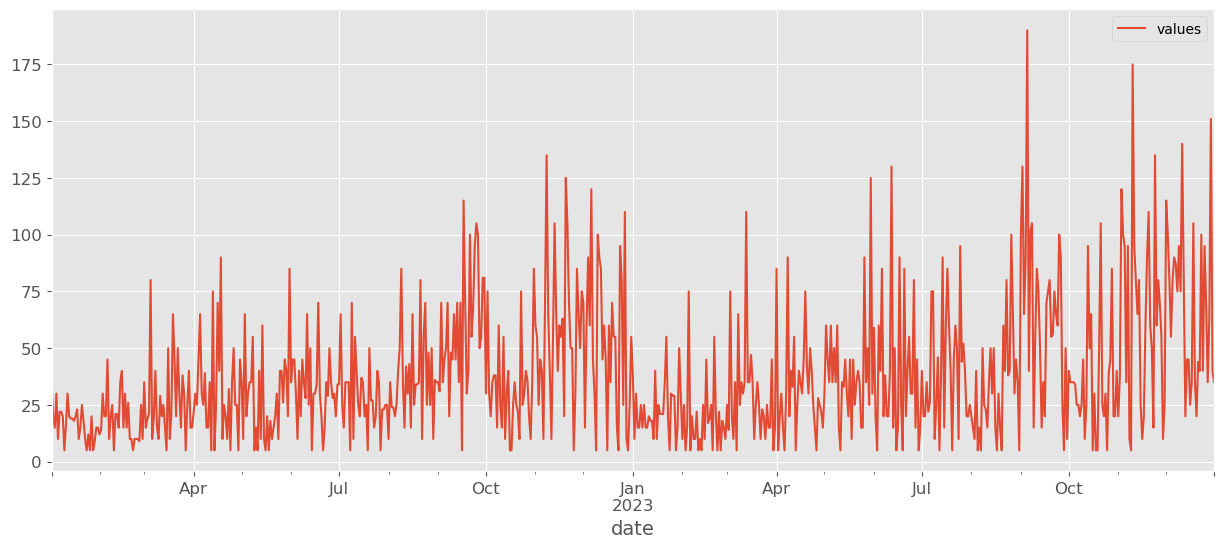

In [8]:
# Plot da série temporal
df.plot(figsize = (15, 6))
plt.show()

## Testes Estatísticos e Modelagem

Para todos os testes estatísticos desta análise, adotaremos um nível de significância de 0.05. Esse valor define o limiar para rejeitarmos a hipótese nula em cada teste, garantindo um equilíbrio entre evitar falsos positivos e falsos negativos. Ou seja, consideraremos um resultado estatisticamente significativo sempre que o valor-p for inferior a 0.05, indicando evidências suficientes para rejeitar a hipótese nula.

### Teste de Dickey-Fuller Aumentado

Vamos utilizar o Teste de Dickey-Fuller Aumentado (ADF) para determinar se a série é estacionária. O ADF é um teste de hipóteses que avalia a existência de uma raiz unitária em uma série temporal, o que é um indicativo de não estacionariedade. Esta informação será relevante para decidir entre uma decomposição aditiva ou multiplicativa.

* Hipótese Nula (H0): A série temporal possui uma raiz unitária e, portanto, é não estacionária.
* Hipótese Alternativa (Ha): A série temporal não possui uma raiz unitária, sugerindo que podemos rejeitar a hipótese nula de não estacionariedade da série.

In [9]:
# Teste Dickey-Fuller

# Print
print('\nResultado do Teste Dickey-Fuller:\n')

# Teste
df_test = adfuller(df.values, autolag = 'AIC')

# Formatando a saída
df_output = pd.Series(df_test[0:4], index = ['Estatística do Teste',
                                          'Valor-p',
                                          'Número de Lags Consideradas',
                                          'Número de Observações Usadas'])

# Loop por cada item da saída do teste
for key,value in df_test[4].items():
    df_output['Valor Crítico (%s)'%key] = value

# Print
print (df_output)


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -2.878283
Valor-p                           0.047932
Número de Lags Consideradas      20.000000
Número de Observações Usadas    708.000000
Valor Crítico (1%)               -3.439620
Valor Crítico (5%)               -2.865631
Valor Crítico (10%)              -2.568948
dtype: float64


Ao analisarmos o resultado do teste podemos fazer algumas considerações:

* O valor-p é menor que a significância de 0.05, porém está muito próximo.
* O estatística do teste está um pouco acima do valor crítico de (5%) reforçando o item acima.
* Apesar do resultado observado sugerir que a série é estacionária, ainda está num limite muito próximo do nível de significância. Portanto, iremos realizar outro teste para garantir que a série é estacionária.

### Teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin)

Vamos utilizar o Teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin) para verificar a estacionariedade da série, uma vez que o resultado do Teste de Dickey-Fuller Aumentado (ADF), não trouxe total confiança por conta do valor-p muito próximo de 0.05.

O KPSS é um teste de hipóteses que avalia se uma série temporal é estacionária em nível ou em tendência, sendo um indicador de estacionariedade se a hipótese nula for rejeitada. Essa informação será importante para decidir entre uma decomposição aditiva ou multiplicativa.

* Hipótese Nula (H0): A série temporal é estacionária, seja em nível ou em tendência.
* Hipótese Alternativa (Ha): A série temporal não é estacionária, rejeitando a hipótese nula de estacionariedade.

In [10]:
# Teste KPSS

# Print
print('\nResultado do Teste KPSS:\n')

# Teste
kpss_test = kpss(df.values)
print(f"\nEstatística do Teste={kpss_test[0]}, \nValor-p={kpss_test[1]}, \nValores Críticos={kpss_test[3]}")


Resultado do Teste KPSS:


Estatística do Teste=1.3757548965909618, 
Valor-p=0.01, 
Valores Críticos={'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Análise:
    
* O valor da estatística do teste é significativamente mais alto do que qualquer um dos valores críticos fornecidos, indicando um forte indicativo de não estacionariedade.
* O valor-p é muito baixo, sugerindo que há apenas 1% de probabilidade de observar uma estatística de teste tão extrema sob a hipótese nula. Isso implica uma forte evidência contra a hipótese nula.
* A série provavelmente é não estacionária.

### Decomposição Multiplicativa

A seguir iremos olhar para a decomposição multiplicativa de nossa série temporal, principalmente para observamos se há uma forte tendência ou não.

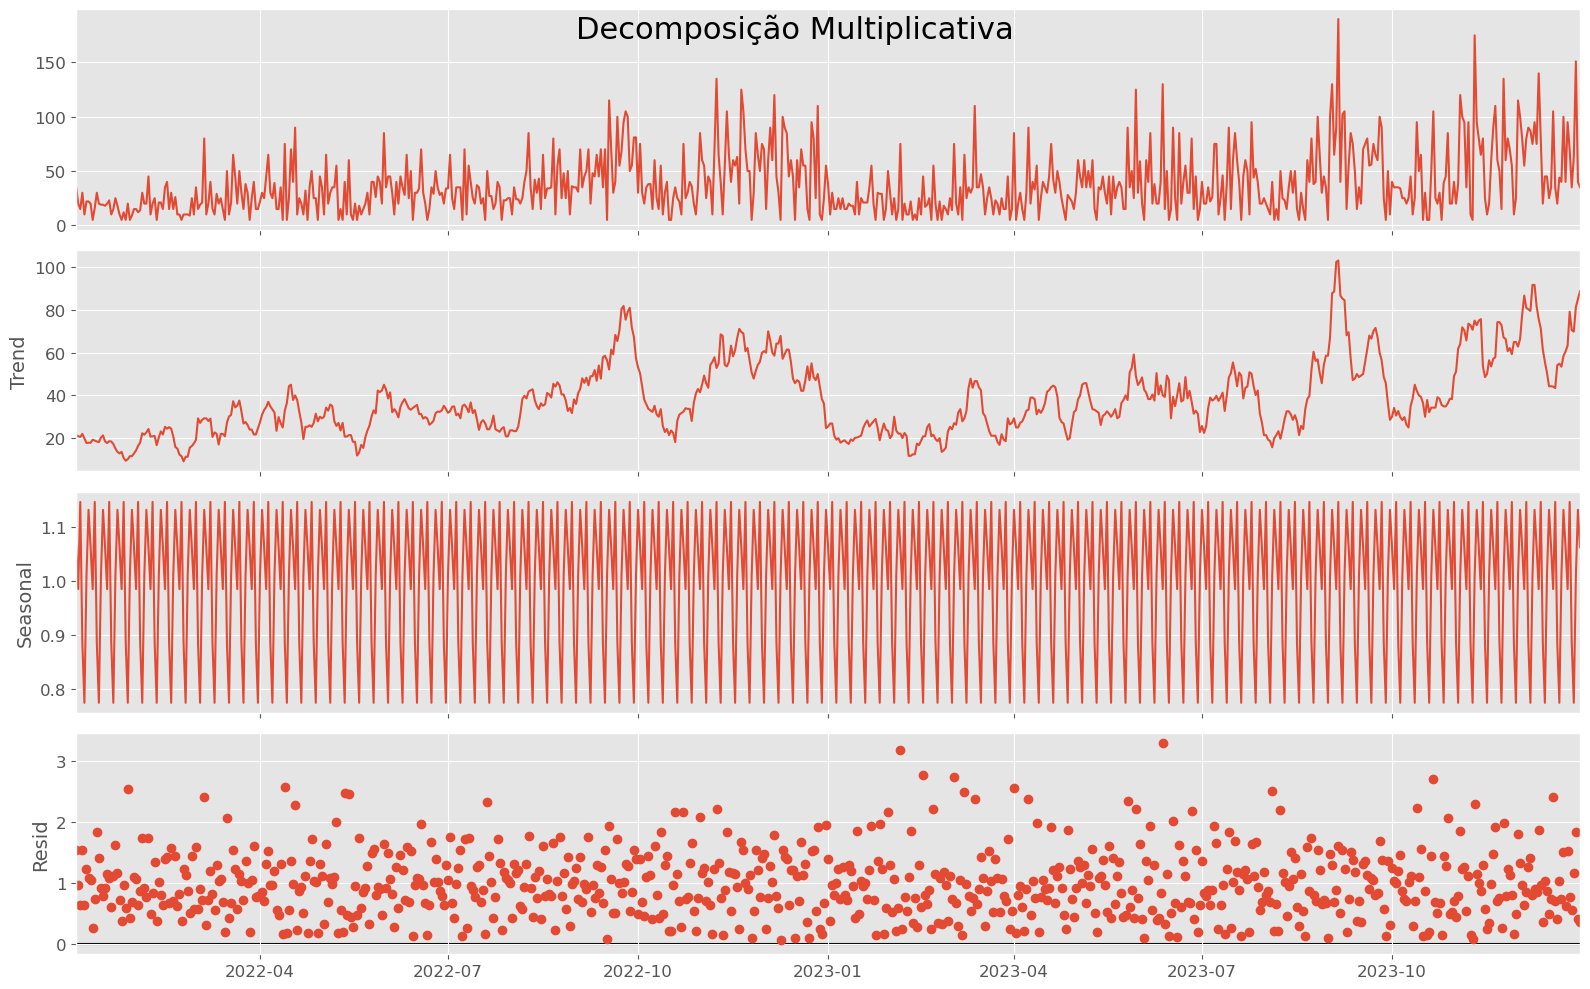

In [11]:
# Decomposição Multiplicativa
multiplicative_decompose = sm.tsa.seasonal_decompose(df,
                                           model = 'multiplicative', 
                                           extrapolate_trend = 'freq')

# Plotando a Decomposição Multiplicativa
plt.rcParams.update({'figure.figsize': (16,10)})
multiplicative_decompose.plot().suptitle('Decomposição Multiplicativa', fontsize = 22)
plt.show()

Ao observamos o item sazonal da nossa decomposição, podemos supor uma forte sazonalidade em nossa série. Portanto, iremos utilizar o modelo SARIMA para a modelagem.

## Modelagem com SARIMA

Vamos utilizar o modelo SARIMA (Seasonal AutoRegressive Integrated Moving Average) para realizar a modelagem preditiva dos dados, pois ele é adequado para séries temporais que apresentam tanto componentes sazonais quanto não sazonais. O SARIMA combina os conceitos do modelo ARIMA com termos adicionais que capturam padrões sazonais, permitindo uma melhor adaptação a séries com recorrências periódicas.

Essa abordagem nos ajudará a capturar a estrutura da série temporal e gerar previsões mais robustas, considerando tanto a tendência quanto a sazonalidade dos dados.

In [12]:
# Modelagem dos dados com SARIMA

# Extraindo os melhores parâmetros para usar no modelo SARIMA com o Autoarima
auto_arima_model = auto_arima(df, 
                              seasonal = True,
                              m=7,
                              trace = True,
                              stepwise=True)

best_order = auto_arima_model.order # Parâmetros do ARIMA (p, d, q)
best_seasonal_order = auto_arima_model.seasonal_order  # Parâmetros sazonais (P, D, Q, m)

# Exibindo quais os melhores parâmetros para nossa modelagem
print(f"\nEstes são os melhores hiperparâmetros para o nosso modelo SARIMA: {best_order} {best_seasonal_order}\n")


# Ajusta (treina) o modelo SARIMA com os melhores hiperparâmetros
sarima_model = SARIMAX(df,
                       order = best_order,
                       seasonal_order=best_seasonal_order)

model_fit = sarima_model.fit()

# Previsões com o modelo para horizonte de 30 dias
forecast = model_fit.forecast(steps = 30)

# Converte forecast para uma série 
forecast_series = pd.Series(forecast, 
                            name = 'forecast', 
                            index = pd.date_range(start = df.index[-1] + pd.Timedelta(days = 1), periods = 30, freq = 'D'))

# Cria DataFrame de previsões com índice de datas e salva em disco
forecast_df = forecast_series.to_frame()
forecast_df['forecast'] = forecast_df['forecast'].round(0)
forecast_df.to_csv(r'.\datasets\04-forecast.csv')

# Exibindo o resultado das previsões
print("O valor de previsão para os próximos 30 dias é:\n")
print(forecast_df)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=6777.910, Time=1.31 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=7217.123, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=7027.003, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=6797.982, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=7215.123, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=6801.814, Time=0.70 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=6799.127, Time=0.59 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=6779.282, Time=2.86 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=6779.336, Time=3.20 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=6811.722, Time=0.22 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=6797.371, Time=1.84 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=6792.371, Time=1.80 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=6781.526, Time=3.38 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=6776.151, Time=1.08 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept

### Teste de Ljung-Box

Vamos utilizar o Teste Ljung-Box para avaliar a autocorrelação dos resíduos do modelo, considerando lags de 1 a 20, a fim de garantir que não exista padrão não capturado nos resíduos. Caso haja autocorrelação significativa, isso pode indicar que o modelo ainda não está adequadamente ajustado. O Teste Ljung-Box é um teste de hipóteses que verifica se há autocorrelação nos resíduos para diferentes lags, sendo essencial para validar a adequação do modelo. Essa análise nos ajudará a confirmar se o modelo está bem especificado ou se ajustes adicionais são necessários.

* Hipótese Nula (H0): Não há autocorrelação nos resíduos para os lags de 1 a 30, indicando que o modelo está adequadamente ajustado.
* Hipótese Alternativa (Ha): Existe autocorrelação nos resíduos para os lags de 1 a 30, sugerindo que o modelo não está totalmente ajustado.

In [13]:
# Obtendo os resíduos do modelo ajustado
residuals = model_fit.resid

# Aplicando o teste de Ljung-Box
ljung_box_results = acorr_ljungbox(residuals, lags=list(range(1, 31)), return_df=True)

# Exibindo os resultados
print("\nTeste de Ljung-Box para autocorrelação nos resíduos:\n")
print(ljung_box_results)


Teste de Ljung-Box para autocorrelação nos resíduos:

      lb_stat  lb_pvalue
1    0.000003   0.998531
2    0.012053   0.993992
3    1.289420   0.731647
4    2.663622   0.615595
5    2.664353   0.751565
6    4.259761   0.641569
7    4.785743   0.686091
8    4.926365   0.765417
9    5.100295   0.825479
10   6.422381   0.778617
11   8.469113   0.670767
12   8.707927   0.727654
13   9.963711   0.696899
14  10.459385   0.727885
15  10.608171   0.779844
16  12.008411   0.743401
17  12.026903   0.798505
18  12.422321   0.824685
19  15.335675   0.701037
20  15.810518   0.728308
21  18.247480   0.633294
22  19.554787   0.610867
23  21.590778   0.545057
24  22.326527   0.559784
25  29.700238   0.235710
26  29.973650   0.268704
27  30.530500   0.290851
28  32.025694   0.273467
29  32.496260   0.298518
30  33.508442   0.300908


Análise:

* Os resíduos não apresentam autocorrelação significativa, pois todos os p-valores são bem maiores que 0.05.
* Isso indica que o modelo SARIMA está bem ajustado e conseguiu capturar os padrões da série.
* Não há necessidade imediata de ajustes no modelo, já que os resíduos parecem ser ruído branco (comportamento aleatório esperado).